In [46]:
# fix for keras v3.0 update
import os
os.environ['TF_USE_LEGACY_KERAS'] = '1' 

# tensorflow
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# python based
import random
from pathlib import Path
import time
import argparse
import json
import submitit
import shutil
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm

# custom code
from OptimizedDataGenerator import OptimizedDataGenerator
from loss import *
from models import *

In [47]:
# set gpu growth
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

output_directory = Path("./training_output").resolve()
batch_size = 500
val_batch_size = 500

if not os.path.exists(output_directory):
    os.mkdir(output_directory)
    
os.makedirs(output_directory, exist_ok=True)
print(output_directory)

# paths
data_directory_path = "/home/elizahoward/cmspix28-mc-sim/minbiasDataSet1/"
    
# create tf records directory
stamp = '%08x' % random.randrange(16**8)
tfrecords_dir_train = Path(output_directory, f"tfrecords_train_{stamp}").resolve()
tfrecords_dir_validation = Path(output_directory, f"tfrecords_validation_{stamp}").resolve()
if not os.path.exists(tfrecords_dir_train):
    os.mkdir(tfrecords_dir_train)
    os.mkdir(tfrecords_dir_validation)

# training generator
start_time = time.time()
training_generator = OptimizedDataGenerator(
    data_directory_path = data_directory_path,
    labels_directory_path = data_directory_path,
    is_directory_recursive = False,
    file_type = "parquet",
    data_format = "3D",
    batch_size = batch_size,
    to_standardize= False,
    include_y_local= False,
    labels_list = ['x-midplane','y-midplane','cotAlpha','cotBeta'],
    input_shape = (2,13,21), # (20,13,21),
    transpose = (0,2,3,1),
    save=True,
    use_time_stamps = [0,19],
    tfrecords_dir = tfrecords_dir_train,
)
print("--- Training generator %s seconds ---" % (time.time() - start_time))

data_directory_path = "/home/elizahoward/cmspix28-mc-sim/minbiasDataSet2/"

start_time = time.time()
validation_generator = OptimizedDataGenerator(
    data_directory_path = data_directory_path,
    labels_directory_path = data_directory_path,
    is_directory_recursive = False,
    file_type = "parquet",
    data_format = "3D",
    batch_size = val_batch_size,
    to_standardize= False,
    include_y_local= False,
    labels_list = ['x-midplane','y-midplane','cotAlpha','cotBeta'],
    input_shape = (2,13,21), # (20,13,21),
    transpose = (0,2,3,1),
    use_time_stamps = [0,19],
    tfrecords_dir = tfrecords_dir_validation,
)
print("--- Validation generator %s seconds ---" % (time.time() - start_time))

/home/elizahoward/smart-pixels-ml/training_output
Directory /home/elizahoward/smart-pixels-ml/training_output/tfrecords_train_0cfb98a9 is removed...


Saving batches as TFRecords: 100%|██████████| 50/50 [00:02<00:00, 19.08it/s]


--- Training generator 9.840966701507568 seconds ---
Directory /home/elizahoward/smart-pixels-ml/training_output/tfrecords_validation_0cfb98a9 is removed...


Saving batches as TFRecords: 100%|██████████| 11/11 [00:01<00:00, 10.60it/s]


--- Validation generator 7.945122718811035 seconds ---


In [48]:
 # compiles model
n_filters = 5 # model number of filters
pool_size = 3 # model pool size
start_time = time.time()
model=CreateModel(shape=(13,21,2), n_filters=n_filters, pool_size=pool_size)
model.summary()
print("--- Model create and compile %s seconds ---" % (time.time() - start_time))

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 13, 21, 2)]       0         
                                                                 
 q_separable_conv2d_2 (QSep  (None, 11, 19, 5)         33        
 arableConv2D)                                                   
                                                                 
 q_activation_10 (QActivati  (None, 11, 19, 5)         0         
 on)                                                             
                                                                 
 q_conv2d_2 (QConv2D)        (None, 11, 19, 5)         30        
                                                                 
 q_activation_11 (QActivati  (None, 11, 19, 5)         0         
 on)                                                             
                                                           

In [85]:
learning_rate = 0.000001
model.compile(optimizer=Adam(learning_rate=learning_rate), loss=custom_loss)

In [86]:
epochs = 10
early_stopping_patience = 50

# launch quick training once gpu is available
es = EarlyStopping(
        patience=early_stopping_patience,
        restore_best_weights=True
)
    
# checkpoint path
checkpoint_filepath = Path(output_directory,"weights", 'weights.{epoch:02d}-t{loss:.2f}-v{val_loss:.2f}.hdf5').resolve()
mcp = tf.keras.callbacks.ModelCheckpoint(
        filepath=checkpoint_filepath,
        save_weights_only=True,
        monitor='val_loss',
        save_best_only=True,
)

# train
history = model.fit(x=training_generator,
                        validation_data=validation_generator,
                        callbacks=[mcp],
                        epochs=epochs,
                        shuffle=False, # shuffling now occurs within the data-loader
                        verbose=1)
    
# clean up tf records
#shutil.rmtree(tfrecords_dir_train)
#shutil.rmtree(tfrecords_dir_validation)

Epoch 1/10
50/50 [==============================] - 6s 71ms/step - loss: -1739.2285 - val_loss: -1267.5804
Epoch 2/10
50/50 [==============================] - 3s 54ms/step - loss: -1709.2688 - val_loss: -1306.5377
Epoch 3/10
50/50 [==============================] - 3s 56ms/step - loss: -1715.3710 - val_loss: -1296.9059
Epoch 4/10
50/50 [==============================] - 3s 56ms/step - loss: -1733.7513 - val_loss: -1273.7675
Epoch 5/10
50/50 [==============================] - 3s 56ms/step - loss: -1712.9333 - val_loss: -1303.4591
Epoch 6/10
50/50 [==============================] - 3s 53ms/step - loss: -1720.8003 - val_loss: -1314.4845
Epoch 7/10
50/50 [==============================] - 3s 56ms/step - loss: -1720.4459 - val_loss: -1321.9087
Epoch 8/10
50/50 [==============================] - 3s 56ms/step - loss: -1724.8109 - val_loss: -668.8593
Epoch 9/10
50/50 [==============================] - 3s 59ms/step - loss: -1680.9318 - val_loss: -1267.8927
Epoch 10/10
50/50 [===================

In [87]:
#model.load_weights("/home/elizahoward/smart-pixels-ml/training_output/weights.07-t-24.69-v-124.79.hdf5")
model.load_weights("/home/elizahoward/smart-pixels-ml/training_output/weights/weights.01-t-1736.73-v-1315.88.hdf5")

In [88]:
p_test = model.predict(validation_generator)

11/11 [==============================] - 1s 64ms/step


In [89]:
complete_truth = None
for _, y in tqdm(validation_generator):
        if complete_truth is None:
            complete_truth = y
        else:
            complete_truth = np.concatenate((complete_truth, y), axis=0)

100%|██████████| 11/11 [00:00<00:00, 29.48it/s]


In [90]:
maxval=1e9
minval=1e-9

# creates df with all predicted values and matrix elements - 4 predictions, all 10 unique matrix elements
df = pd.DataFrame(p_test,columns=['x','M11','y','M22','cotA','M33','cotB','M44','M21','M31','M32','M41','M42','M43'])
df['x'] *= 75
df['y'] *= 18.75
df['cotA'] *= 8
df['cotB'] *= 0.5

# stores all true values in same matrix as xtrue, ytrue, etc.
df['xtrue'] = complete_truth[:,0]*75
df['ytrue'] = complete_truth[:,1]*18.75
df['cotAtrue'] = complete_truth[:,2]*8
df['cotBtrue'] = complete_truth[:,3]*0.5
df['M11'] = minval+tf.math.maximum(df['M11'], 0)
df['M22'] = minval+tf.math.maximum(df['M22'], 0)
df['M33'] = minval+tf.math.maximum(df['M33'], 0)
df['M44'] = minval+tf.math.maximum(df['M44'], 0)

df['sigmax'] = abs(df['M11'])
df['sigmay'] = np.sqrt(df['M21']**2 + df['M22']**2)
df['sigmacotA'] = np.sqrt(df['M31']**2+df['M32']**2+df['M33']**2)
df['sigmacotB'] = np.sqrt(df['M41']**2+df['M42']**2+df['M43']**2+df['M44']**2)

# calculates residuals for x, y, cotA, cotB
residualsx = np.abs(df['xtrue'] - df['x'])
residualsy = np.abs(df['ytrue'] - df['y'])
residualsA = np.abs(df['cotAtrue'] - df['cotA'])
residualsB = np.abs(df['cotBtrue'] - df['cotB'])

# stores results as csv
df.to_csv("test_4x4.csv",header=True,index=False)

In [91]:
# x
xmean, xstd = (np.mean(residualsx),np.std(residualsx))
print(f"mean and std residuals for x-midplane: ({xmean},{xstd})")
# y
ymean, ystd = (np.mean(residualsy),np.std(residualsy))
print(f"mean and std residuals for y-midplane: ({ymean},{ystd})")
# cotA
cotAmean, cotAstd = (np.mean(residualsA),np.std(residualsA))
print(f"mean and std residuals for cot(alpha): ({cotAmean},{cotAstd})")
# cotB
cotBmean, cotBstd = (np.mean(residualsB),np.std(residualsB))
print(f"mean and std residuals for cot(beta): ({cotBmean},{cotBstd})")


mean and std residuals for x-midplane: (9.96383285522461,10.47316837310791)
mean and std residuals for y-midplane: (1.8704382181167603,1.9298443794250488)
mean and std residuals for cot(alpha): (0.27927595376968384,0.28376325964927673)
mean and std residuals for cot(beta): (0.04735834151506424,0.05017533153295517)


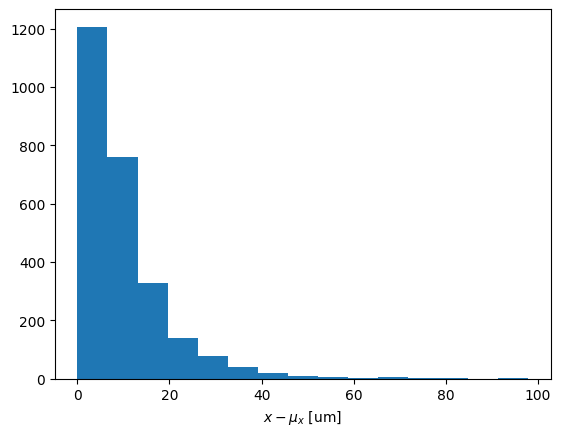

In [92]:
plt.hist(residualsx, bins = 15)
#plt.yscale('Log')
plt.xlabel(r'$x-\mu_x$ [um]')

#save_fig_path = os.path.join(base_dir, 'x_res_dist.png')
#plt.savefig(save_fig_path)

plt.show()

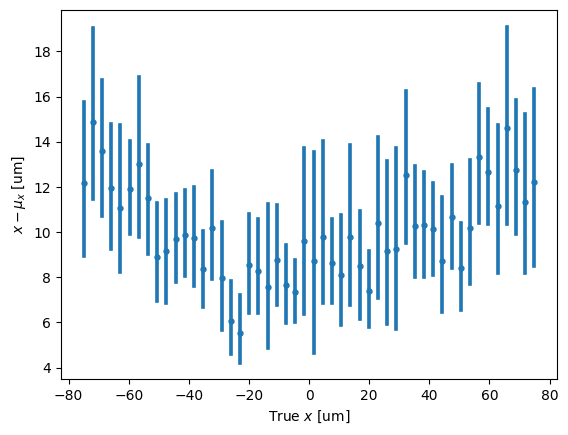

In [93]:
x = sns.regplot(x=df['xtrue'], y=residualsx, x_bins=np.linspace(-75,75,50), fit_reg=None, marker='.')
plt.xlabel(r'True $x$ [um]')
plt.ylabel(r'$x-\mu_x$ [um]')

#save_fig_path = os.path.join(base_dir, 'x_vs_res.png')
#plt.savefig(save_fig_path)

plt.show()